In [1]:
import metpy
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import fsspec
import gcsfs
from emfunc import read_imd_daily
from emfunc import read_era5_summaries
import metpy.calc
from metpy.units import units
from emfunc import read_era5
import xclim
from emfunc import read_imd_fcst_mh_daily
from mpl_toolkits.basemap import Basemap
import xarrayMannKendall as xmk
import pymannkendall as mk
import geopandas
from shapely.geometry import mapping

In [2]:
from emfunc import read_imdaa_reanalysis

data_type = 'grid'

# Note that we filter using UTC times here
start_time = pd.Timestamp(year = 1980, month = 12, day = 31, hour = 19)
end_time = pd.Timestamp(year = 2020, month = 12, day = 31, hour = 18)

dataset = read_imdaa_reanalysis(data_type, start_time, end_time, latitude_bounds = [20, 25], longitude_bounds = [68, 75])

dataset

converting to IST


<xarray.Dataset>
Dimensions:    (time: 350640, latitude: 42, longitude: 58)
Coordinates:
  * latitude   (latitude) float64 20.04 20.16 20.28 20.4 ... 24.72 24.84 24.96
  * longitude  (longitude) float64 68.04 68.16 68.28 68.4 ... 74.64 74.76 74.88
  * time       (time) datetime64[ns] 1981-01-01T00:30:00 ... 2020-12-31T23:30:00
Data variables:
    APCP_sfc   (time, latitude, longitude) float32 dask.array<chunksize=(275, 17, 25), meta=np.ndarray>
    RH_2m      (time, latitude, longitude) float32 dask.array<chunksize=(275, 17, 25), meta=np.ndarray>
    TMP_2m     (time, latitude, longitude) float32 dask.array<chunksize=(275, 17, 25), meta=np.ndarray>
    UGRD_50m   (time, latitude, longitude) float32 dask.array<chunksize=(275, 17, 25), meta=np.ndarray>
    VGRD_50m   (time, latitude, longitude) float32 dask.array<chunksize=(275, 17, 25), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    Conventions:          COARDS
    GRIB2_grid_template:  0
    History:              created by wgrib2
    history:              Wed Jul 05 11:22:11 2023: cdo -f nc4c -z zip_4 copy...

In [3]:
temp = dataset['TMP_2m']
precip = dataset['APCP_sfc']

In [4]:
tmax = temp.resample(time='D').max()
tmin = temp.resample(time='D').min()
rain = precip.resample(time='D').sum()

In [5]:
summer_tmax = tmax.sel(time=tmax['time.month'].isin([3, 4, 5, 6]))
summer_tmin = tmin.sel(time=tmin['time.month'].isin([3, 4, 5, 6]))

In [6]:
summer_tmax = summer_tmax.compute()

In [7]:
summer_tmin = summer_tmin.compute()

In [8]:
summer_tmin = summer_tmin - 273
summer_tmax = summer_tmax - 273

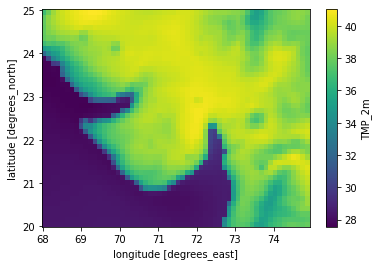

In [9]:
summer_tmax.mean('time').plot()

In [9]:
#preparing the rainfall data
rain = rain.sel(time=rain['time.month'].isin([6, 7, 8, 9]))

In [10]:
rain = rain.compute()

Analysis for precipitation

In [13]:
#calculating rainfall hotspots for p90 and p99
pr = rain
pr.attrs["units"] ="mm/day"

In [54]:
JJAS = pr.groupby('time.year').sum(dim='time')

In [55]:
JJAS

<xarray.DataArray 'APCP_sfc' (year: 40, latitude: 42, longitude: 58)>
array([[[ 216.5586  ,  225.3164  ,  227.60156 , ...,  458.76953 ,
          446.35938 ,  435.30078 ],
        [ 238.79297 ,  253.46094 ,  250.45312 , ...,  485.79297 ,
          466.9922  ,  458.5     ],
        [ 236.6836  ,  254.69531 ,  270.23828 , ...,  544.6953  ,
          553.3867  ,  526.9375  ],
        ...,
        [ 174.67578 ,  191.08984 ,  212.7539  , ...,  669.9297  ,
          654.91016 ,  639.46094 ],
        [ 151.5664  ,  182.28906 ,  217.75781 , ...,  678.6992  ,
          667.9844  ,  645.28125 ],
        [ 160.10547 ,  178.08984 ,  213.58594 , ...,  671.1289  ,
          660.2656  ,  655.5547  ]],

       [[ 204.28906 ,  208.96094 ,  219.03906 , ...,  280.03906 ,
          304.78906 ,  323.08203 ],
        [ 211.54688 ,  217.34375 ,  221.9375  , ...,  292.4414  ,
          300.08203 ,  302.5039  ],
        [ 205.91016 ,  207.73438 ,  213.1875  , ...,  276.79688 ,
          275.48438 ,  280.91016 ],
...
        [ 587.7617  ,  466.8711  ,  455.8125  , ...,  936.22656 ,
          939.09766 ,  905.60547 ],
        [ 531.52344 ,  470.8086  ,  433.4414  , ...,  988.03906 ,
          973.2344  ,  909.1797  ],
        [ 527.64453 ,  501.03125 ,  348.53516 , ..., 1001.6289  ,
         1004.7539  ,  960.58594 ]],

       [[ 761.1953  ,  787.20703 ,  807.66797 , ...,  952.4375  ,
          982.89844 ,  995.59375 ],
        [ 740.52344 ,  785.3047  ,  820.1406  , ...,  926.0586  ,
          950.8672  ,  976.1875  ],
        [ 719.1211  ,  756.0039  ,  785.71875 , ...,  950.125   ,
          956.96484 ,  969.83594 ],
        ...,
        [ 370.91797 ,  389.6172  ,  391.72656 , ...,  651.28125 ,
          651.41016 ,  655.1875  ],
        [ 324.375   ,  356.6211  ,  370.42188 , ...,  663.3281  ,
          658.2031  ,  640.9297  ],
        [ 288.64844 ,  283.09766 ,  312.16406 , ...,  672.6758  ,
          659.6367  ,  629.91797 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 20.04 20.16 20.28 20.4 ... 24.72 24.84 24.96
  * longitude  (longitude) float64 68.04 68.16 68.28 68.4 ... 74.64 74.76 74.88
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2017 2018 2019 2020
Attributes:
    level:       surface
    long_name:   Total Precipitation
    short_name:  APCP_surface
    units:       mm/day

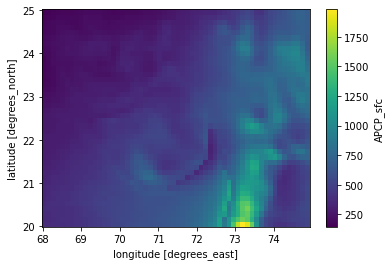

In [19]:
JJAS.mean('year').plot()

In [20]:
#heavy and very heavy rainfall events
from xclim.indices import days_over_precip_thresh
pq = pr.sel(time=slice("1980-01-01", "2009-01-01"))
p90 = pq.quantile(0.9, dim="time", keep_attrs=True)
heavy = days_over_precip_thresh(pr, p90)

In [21]:
from xclim.indices import days_over_precip_thresh
pq = pr.sel(time=slice("1981-01-01", "2005-01-01"))
p90 = pq.quantile(0.99, dim="time", keep_attrs=True)
vheavy = days_over_precip_thresh(pr, p90)

In [22]:
heavy_decade = heavy.sel(time=slice("2009-01-01", "2021-01-01"))
vheavy_decade = vheavy.sel(time=slice("2009-01-01", "2021-01-01"))
heavy_old = heavy.sel(time=slice("1980-01-01", "2009-01-01"))
vheavy_old = vheavy.sel(time=slice("1980-01-01", "2009-01-01"))

In [23]:
#Anomalies
JJAS_heavy_anomaly = (heavy.sel(time=slice("2009", "2022")).mean('time')) - (heavy.sel(time=slice("1980", "2009")).mean('time'))
JJAS_vheavy_anomaly = (vheavy.sel(time=slice("2009", "2022")).mean('time')) - (vheavy.sel(time=slice("1980", "2009")).mean('time'))

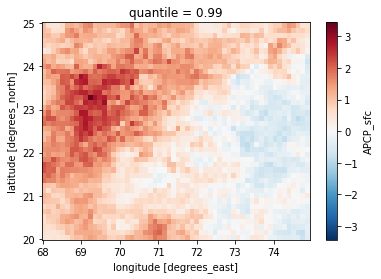

In [25]:
JJAS_vheavy_anomaly.plot()

In [30]:
JJAS_heavy_anomaly.to_netcdf('p90_increase.nc')
JJAS_vheavy_anomaly.to_netcdf('p99_increase.nc')

In [46]:
# Define the latitude and longitude boundaries for clipping
lat_min = 22  # Minimum latitude
lat_max = 25  # Maximum latitude
lon_min = 68 # Minimum longitude
lon_max = 72  # Maximum longitude

# Clip the xarray.Dataset to the specified region
p90_decade = heavy_decade.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
p90_baseline = heavy_old.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

In [42]:
p90_decade.mean('time').to_netcdf('p90_decade_thane.nc')
p90_baseline.mean('time').to_netcdf('p90_baseline_thane.nc')

In [77]:
#Calculating excessive and deficient rainfall years
#calculating deficient, normal and excess rain years
#Define the Lower Percentage Anomaly (LPA) range
lpa_percentage_range = [-19, 19]

# Calculate the LPA as the average from 1981-2010
lpa = JJAS.sel(year=slice(1980, 2009)).mean(dim='year')

# Calculate the percentage deviation from LPA for each year
percentage_deviation = ((JJAS - lpa) / lpa) * 100

# Create a mask for deficient, normal, and excessive rainfall years
deficient_mask = (percentage_deviation < lpa_percentage_range[0]).astype(int)
normal_mask = ((percentage_deviation >= lpa_percentage_range[0]) & (percentage_deviation <= lpa_percentage_range[1])).astype(int)
excessive_mask = (percentage_deviation > lpa_percentage_range[1]).astype(int)

# Calculate the total number of deficient, normal, and excessive rainfall years
deficient_years = deficient_mask.sum(dim='year')
normal_years = normal_mask.sum(dim='year')
excessive_years = excessive_mask.sum(dim='year')

In [78]:
deficient_years.to_netcdf('0_JJAS_deficient_years.nc')
excessive_years.to_netcdf('0_JJAS_excessive_years.nc')

In [81]:
JJAS_anomaly = (JJAS.sel(year=slice("2009", "2022")).mean('year')) - (JJAS.sel(year=slice("1980", "2009")).mean('year'))

In [83]:
JJAS_anomaly.mean()

<xarray.DataArray 'APCP_sfc' ()>
array(175.32326, dtype=float32)
Coordinates:
    spatial_ref  int64 0

Hot days and warm nights analysis

For plotting. Please change the ds to the netcdf to plot

In [48]:
# Define the latitude and longitude boundaries for clipping
lat_min = 22  # Minimum latitude
lat_max = 25  # Maximum latitude
lon_min = 68 # Minimum longitude
lon_max = 72  # Maximum longitude

# Clip the xarray.Dataset to the specified region
heavy_kutch = JJAS_heavy_anomaly.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
vheavy_kutch = JJAS_vheavy_anomaly.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

In [51]:
heavy_kutch.to_netcdf('Heavy_Kutch.nc')
vheavy_kutch.to_netcdf('Vheavy_Kutch.nc')

In [29]:
#plotting summer temperatures 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr

# Load the NetCDF file using xarray
ds = JJAS_heavy_anomaly

shapefile_path = 'Kutch_SD.shp'
gdf = gpd.read_file(shapefile_path)

In [32]:
gdf

,District,STATE,TEHSIL,Shape_Leng,Shape_Area,geometry
0,KACHCHH,GUJARAT,Abdasa,4.386000e+05,2.279531e+09,"MULTIPOLYGON (((68.76085 23.48172, 68.76149 23..."
1,KACHCHH,GUJARAT,Anj<r,2.770182e+05,1.128377e+09,"POLYGON ((70.15303 23.38954, 70.15369 23.38753..."
2,KACHCHH,GUJARAT,Bhach<u,2.452849e+06,2.140069e+10,"MULTIPOLYGON (((70.25765 23.17380, 70.25781 23..."
3,KACHCHH,GUJARAT,Bhuj,8.053453e+05,5.209221e+09,"POLYGON ((69.77134 23.97978, 69.77206 23.97979..."
4,KACHCHH,GUJARAT,G<ndh\dh<m,1.259940e+05,2.516324e+08,"POLYGON ((70.21199 23.17219, 70.20798 23.16786..."
5,KACHCHH,GUJARAT,Lakhpat,3.772723e+05,1.834026e+09,"MULTIPOLYGON (((68.52924 23.68865, 68.53035 23..."
6,KACHCHH,GUJARAT,M<ndvi,2.516947e+05,1.388326e+09,"POLYGON ((69.32895 23.15288, 69.33620 23.15007..."
7,KACHCHH,GUJARAT,Mundra,1.974383e+05,8.550656e+08,"POLYGON ((69.65379 23.05002, 69.65430 23.05002..."
8,KACHCHH,GUJARAT,Nakhtar<na,3.367334e+05,1.923773e+09,"POLYGON ((68.97016 23.62985, 68.97402 23.62878..."
9,KACHCHH,GUJARAT,Rann of Kachchh,2.598771e+04,1.826622e+07,"POLYGON ((69.59637 23.77594, 69.59570 23.77522..."


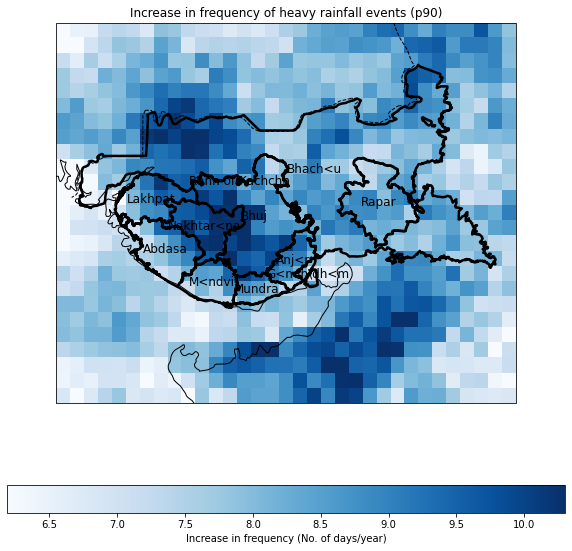

In [41]:
# Load the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load the shapefile ('Thane.shp')
shapefile_path = 'Kutch_SD.shp'
gdf = gpd.read_file(shapefile_path)

# Create a figure and axis with Cartopy projection
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the precipitation anomaly data with imshow without showing the legend
pcm = ds_clipped.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', robust=True, add_colorbar=False)

# Overlay the shapefile with darker and black boundaries
gdf.boundary.plot(ax=ax, linewidth=2.5, color='black')  # Adjust linewidth and color

# Add labels from 'THNAME' column
for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['TEHSIL']):
    ax.text(x, y, label, fontsize=12, ha='center', va='center', color='black', backgroundcolor='none')

# Customize the plot with title, labels, and legend if needed
plt.title('Increase in frequency of heavy rainfall events (p90)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add coastlines, country borders, rivers, and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='--')

# Create a colorbar for the precipitation anomaly data with horizontal legend
cbar = plt.colorbar(pcm, ax=ax, label='Increase in frequency (No. of days/year)', orientation='horizontal')

# Show the plot
plt.show()

In [53]:
# Save the figure in high resolution (500 dpi)
output_path = 'precipitation_anomaly_map.png'  # Specify the output file path
fig.savefig(output_path, dpi=500, bbox_inches='tight')

# Print a message indicating that the figure has been saved
print(f'Figure saved as {output_path}')

Figure saved as precipitation_anomaly_map.png


In [89]:
#Trend analysis of p90 and p99
ds = heavy
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Kutch_SD.shp', crs="epsg:4326")
heavy_trend = CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)


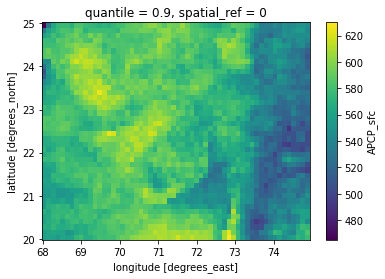

In [96]:
heavy.sum('time').plot()

In [109]:
# Define the latitude and longitude boundaries for clipping
lat_min = 22  # Minimum latitude
lat_max = 25  # Maximum latitude
lon_min = 68 # Minimum longitude
lon_max = 72  # Maximum longitude

# Clip the xarray.Dataset to the specified region
Kutch_vheavy = JJAS_vheavy_anomaly.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

In [103]:
trend1 = Kutch_heavy.rolling(time=1).mean().mean(dim=['latitude', 'longitude'])

In [105]:
df = trend1.to_dataframe(name = 'two_spell')

In [112]:
Kutch_vheavy.mean()

<xarray.DataArray 'APCP_sfc' ()>
array(1.44815047)
Coordinates:
    quantile  float64 0.99

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 'JJAS' and 'rainfall' defined

# Calculate trendline
x = trend.time.values
y = trend.values
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Calculate R-squared value
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean)**2)
ss_residual = np.sum((y - trendline(x))**2)
r_squared = 1 - (ss_residual / ss_total)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Create line plot
ax.plot(trend.time, trend)

# Add trendline to plot with blue color
ax.plot(trend.time, trendline(trend.time), linestyle='--', color='blue', label=f'Trendline (R2 = {r_squared:.2f})')

# Add titles and labels
ax.set_title('Trends in southwest monsoon rainfall (JJAS) over Kutch from 1982-2022')
ax.set_xlabel('Time')
ax.set_ylabel('Rainfall (mm)')

# Set x-axis labels at an interval of two years
ax.set_xticks(trend.time[::3])

# Display legend
ax.legend()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [76]:
# Save the plot as a high-resolution image
output_file = 'JJAS_trend.png'  # Adjust the file name and format as needed
plt.savefig(output_file, dpi=600, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [21]:
from xclim.indices import days_over_precip_thresh
pq = pr.sel(time=slice("1981-01-01", "2005-01-01"))
p90 = pq.quantile(0.99, dim="time", keep_attrs=True)
vheavy = days_over_precip_thresh(pr, p90)

In [26]:
hd = heavy.sel(time=slice("2010-01-01", "2021-01-01"))
vhd = vheavy.sel(time=slice("2010-01-01", "2021-01-01"))

In [29]:
#Anomalies
JJAS_heavy_anomaly = (heavy.sel(time=slice("2010", "2022")).mean('time')) - (heavy.sel(time=slice("1980", "2009")).mean('time'))
JJAS_vheavy_anomaly = (vheavy.sel(time=slice("2010", "2022")).mean('time')) - (vheavy.sel(time=slice("1980", "2009")).mean('time'))

In [32]:
JJAS_heavy_anomaly.to_netcdf('anomaly_p90.nc')
JJAS_vheavy_anomaly.to_netcdf('anomaly_p99.nc')

In [33]:
hd.sum('time').to_netcdf('p90_decade.nc')
vhd.sum('time').to_netcdf('p99_decade.nc')

Temperature hotspots

In [43]:
summer_tmax.attrs["units"] ="degC"

In [44]:
#90th percentile
#Frequency of hot days based on thresholds for 1971-2010
from xclim.core.calendar import percentile_doy
from xclim.indices import tx90p
tas_pr = summer_tmax.sel(time=slice("1981-01-01", "2010-01-01"))
tas = summer_tmax
tas_per = percentile_doy(tas_pr, per=90).sel(percentiles=90)
hot_days = tx90p(tas, tas_per, freq = 'YS', op = '>=')

In [45]:
summer_tmin.attrs['units'] = "degC"

In [46]:
#90th percentile
#Frequency of hot days based on thresholds for 1971-2010
from xclim.core.calendar import percentile_doy
from xclim.indices import tn90p
tas_pr = summer_tmin.sel(time=slice("1981-01-01", "2010-01-01"))
tas = summer_tmin
tas_per = percentile_doy(tas_pr, per=90).sel(percentiles=90)
warm_nights = tn90p(tas, tas_per, freq = 'YS', op = '>=')

In [47]:
hot_days

<xarray.DataArray (time: 40, latitude: 17, longitude: 17)>
array([[[14, 14, 13, ...,  8,  9, 11],
        [14, 14, 11, ...,  9,  8,  8],
        [13, 15, 13, ..., 12,  8, 11],
        ...,
        [ 8,  9,  9, ..., 17, 17, 16],
        [ 8,  9, 10, ..., 17, 17, 15],
        [10, 10, 11, ..., 17, 16, 16]],

       [[ 0,  0,  0, ...,  6,  5,  5],
        [ 0,  0,  0, ...,  8,  5,  5],
        [ 0,  0,  0, ...,  8,  4,  5],
        ...,
        [ 3,  3,  3, ...,  5,  5,  6],
        [ 3,  3,  3, ...,  6,  6,  9],
        [ 3,  3,  3, ...,  5,  7,  9]],

       [[ 0,  0,  0, ..., 12, 16, 13],
        [ 0,  0,  0, ..., 13, 17, 14],
        [ 0,  0,  0, ..., 14, 15, 15],
        ...,
...
        ...,
        [34, 32, 31, ...,  8,  9, 12],
        [40, 33, 34, ..., 10, 11, 12],
        [38, 39, 34, ...,  9, 14, 13]],

       [[16, 18, 20, ..., 41, 30, 30],
        [19, 19, 19, ..., 39, 36, 34],
        [18, 20, 23, ..., 39, 39, 35],
        ...,
        [13, 14, 16, ..., 33, 35, 32],
        [15, 15, 14, ..., 32, 33, 30],
        [14, 15, 16, ..., 35, 34, 33]],

       [[51, 49, 48, ..., 13,  8,  9],
        [50, 51, 51, ..., 11,  9,  9],
        [52, 51, 50, ..., 14, 13, 10],
        ...,
        [34, 36, 31, ..., 15, 14, 13],
        [38, 41, 37, ..., 15, 13, 13],
        [39, 42, 41, ..., 14, 15, 13]]])
Coordinates:
  * latitude     (latitude) float64 18.0 18.12 18.24 18.36 ... 19.68 19.8 19.92
  * longitude    (longitude) float64 72.0 72.12 72.24 72.36 ... 73.68 73.8 73.92
    percentiles  int64 90
  * time         (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2020-01-01
Attributes:
    units:    d

In [48]:
# Define the latitude and longitude boundaries for clipping
lat_min = 18.75  # Minimum latitude
lat_max = 19.75  # Maximum latitude
lon_min = 72.75 # Minimum longitude
lon_max = 74.0  # Maximum longitude

# Clip the xarray.Dataset to the specified region
hot_days = hot_days.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
warm_nights = warm_nights.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

In [49]:
hd_decade = hot_days.sel(time=slice("2010-01-01", "2021-01-01"))
wn_decade = warm_nights.sel(time=slice("2010-01-01", "2021-01-01"))
hd_baseline = hot_days.sel(time=slice("1980-01-01", "2009-01-01"))
wn_baseline = warm_nights.sel(time=slice("1980-01-01", "2009-01-01"))

In [51]:
hd_decade.mean('time').to_netcdf('hd_decade_thane.nc')
hd_baseline.mean('time').to_netcdf('hd_baseline_thane.nc')

In [52]:
wn_decade.mean('time').to_netcdf('wn_decade_thane.nc')
wn_baseline.mean('time').to_netcdf('wn_baseline_thane.nc')

In [61]:
hd.sum('time').to_netcdf('hot_days.nc')
wn.sum('time').to_netcdf('warm_nights.nc')

In [53]:
#Anomalies
hd_anomaly = (hot_days.sel(time=slice("2010", "2022")).mean('time')) - (hot_days.sel(time=slice("1980", "2009")).mean('time'))
wn_anomaly = (warm_nights.sel(time=slice("2010", "2022")).mean('time')) - (warm_nights.sel(time=slice("1980", "2009")).mean('time'))

In [59]:
ds = wn_anomaly
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Thane.shp', crs="epsg:4326")
clipped = CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)
clipped.mean()

<xarray.DataArray ()>
array(11.65216823)
Coordinates:
    percentiles  int64 90
    spatial_ref  int64 0

In [63]:
hd_anomaly.to_netcdf('hot_days_anomaly.nc')
wn_anomaly.to_netcdf('warm_nights_anomaly.nc')

In [66]:
#trends in monsoon rainfall over Thane
JJAS = rain.sel(time=rain['time.month'].isin([6, 7, 8, 9]))
OND = rain.sel(time=rain['time.month'].isin([10,11,12]))

In [67]:
JJAS = JJAS.compute()
OND = OND.compute()

In [68]:
ds = JJAS
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Thane.shp', crs="epsg:4326")
clipped = CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)

In [70]:
JJAS = clipped

In [71]:
ds = OND
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Thane.shp', crs="epsg:4326")
OND = CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)

In [73]:
sw = JJAS.groupby('time.year').sum(dim='time')
ne = OND.groupby('time.year').sum(dim='time')

In [83]:
ds = ne
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Thane.shp', crs="epsg:4326")
sw= CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)

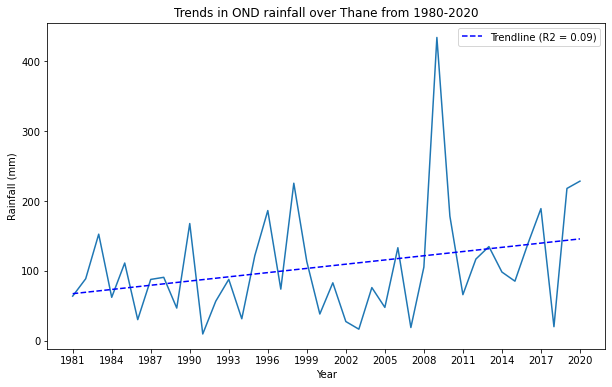

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 'vhintensity' and 'rainfall' defined
rainfall = sw.mean(dim=('latitude', 'longitude'))

# Calculate trendline
x = sw.year.values
y = rainfall.values
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Calculate R-squared value
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean)**2)
ss_residual = np.sum((y - trendline(x))**2)
r_squared = 1 - (ss_residual / ss_total)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Create line plot
ax.plot(sw.year, rainfall)

# Add trendline to plot with blue color
ax.plot(sw.year, trendline(sw.year), linestyle='--', color='blue', label=f'Trendline (R2 = {r_squared:.2f})')

# Add titles and labels
ax.set_title('Trends in OND rainfall over Thane from 1980-2020')
ax.set_xlabel('Year')
ax.set_ylabel('Rainfall (mm)')

# Set x-axis labels at an interval of two years
ax.set_xticks(sw.year[::3])

# Display legend
ax.legend()

# Save the plot as a high-resolution image
output_file = 'trendline_plot.png'  # Adjust the file name and format as needed
plt.savefig(output_file, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

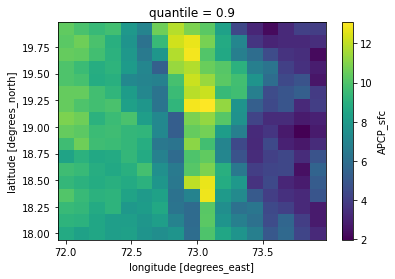

In [87]:
#calculating anomalies
JJAS_heavy_anomaly.plot()

In [94]:
ds = wn_anomaly
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Thane.shp', crs="epsg:4326")
clipped = CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)
clipped.mean(dim=['latitude', 'longitude'])

<xarray.DataArray ()>
array(11.65216823)
Coordinates:
    percentiles  int64 90
    spatial_ref  int64 0

In [97]:
ds = ne
CHIRPS_daily = ds
CHIRPS_daily.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
CHIRPS_daily.rio.write_crs("epsg:4326", inplace=True)
Shapefile = geopandas.read_file('Thane.shp', crs="epsg:4326")
ne = CHIRPS_daily.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)

In [99]:
OND_anomaly = (ne.sel(year=slice("2011", "2020")).mean('year')) - (ne.sel(year=slice("1980", "2011")).mean('year'))

In [102]:
OND_anomaly.mean(dim=['latitude', 'longitude'])

<xarray.DataArray 'APCP_sfc' ()>
array(31.794548, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [1]:
hot_days

NameError: name 'hot_days' is not defined